In [1]:
import FireFightingEnv as FFEnv
import torch
import torch.optim as optim
import random
import math
import time
from collections import namedtuple, deque
from itertools import count
import torch.nn as nn
import imageio

# Test num is the number of run we trained to evaluate, as mentioned in our reports
test_num=8

# This 'eval' can evaluate DQN, Policy Gradiant, and ActorCritic
# For DQN evaluation, please set model_name = ''
# For Policy Gradient evaluation, please set model_name = 'PG'
# For Actor Critic evaluation, please set model_name = 'AC'
model_name = ''

# e.g. to test run8 of DQN, set: test_num = 8, model_name = ''


if model_name == 'AC':
    from ACNet_Real import ACNet
else:
    from ACNet_v1 import ACNet

AGT_COUNT = 3
GRID_SIZE = 5

def test_model(policy_net, env, num_episodes=10):
    policy_net.eval()  
    fire_frames = []
    fire_agent_frames = []
    env_frames = []

    for i_episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            actions = []
            for s in state:
                input = torch.from_numpy(s[0]).float().to(device)  
                water_res = torch.tensor([[s[1]]]).float().to(device)
                if model_name == 'AC':
                    action_i, _ = policy_net(input.unsqueeze(0), water_res)
                    action_i = action_i.max(1)[1].view(1, 1)
                else:
                    action_i = policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1)
                action_int = action_i.item()
                action = [action_int % 5, int(action_int / 5)]
                actions.append(action)

            next_state, reward, done = env.step(actions)


            total_reward += sum(reward)

            state = next_state

            fire_frames.append(env.mapEnv.figFire())
            env_frames.append(env.mapEnv.figEnv())
            fire_agent_frames.append(env.mapEnv.figFireAgent())
            
            if done:
                print(f"Episode {i_episode + 1}, Total Reward: {total_reward}")
                imageio.mimsave('./results/gif/environment' + model_name + str(test_num) + '.gif', env_frames, duration=0.5)
                # imageio.mimsave('./results/gif/fire.gif', fire_frames, duration=0.5)
                imageio.mimsave('./results/gif/fire_agent' + model_name + str(test_num) + '.gif', fire_agent_frames, duration=0.5)
                break




In [2]:

env = FFEnv.FFEnv(3)  

policy_net = ACNet(10, GRID_SIZE) 

checkpoint = torch.load('./results/checkpoint/Run'+ model_name  + str(test_num) + '.pth')  
policy_net.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)


ACNet(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 116, kernel_size=(3, 3), stride=(1, 1))
  (fc0): Linear(in_features=1, out_features=12, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc_policy): Linear(

In [3]:
# For testing of one complete episode 
# Set TEST_ALL to 1 to test the complete episode, set to 0 otherwise

TEST_ALL = 1
if(TEST_ALL):
    test_model(policy_net, env, num_episodes=1)


In [4]:
# For testing the model step by step
# Set TEST_VIEW_SINGLE_STEP to 1 to see the step by step action of the agent, set to 0 otherwise
# Excecute the next cell repeativly to see the agent and environment change step by step

TEST_VIEW_SINGLE_STEP = 1
if(TEST_VIEW_SINGLE_STEP):
    policy_net.eval()  

    state = env.reset()
    total_reward = 0


[[1, 0], [1, 0], [1, 0]]
[0.05 0.05 0.05]


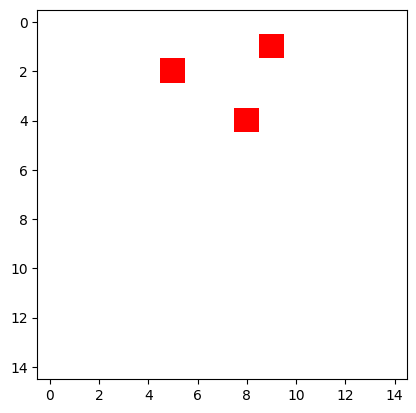

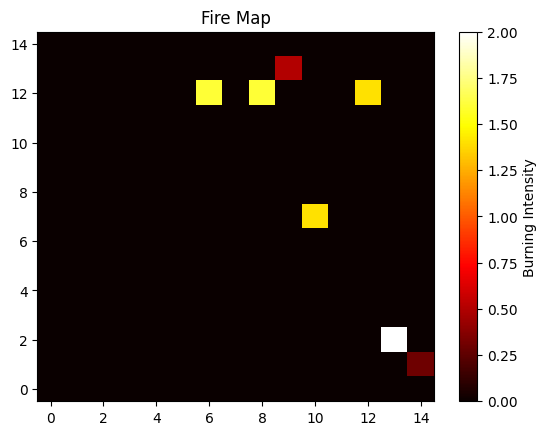

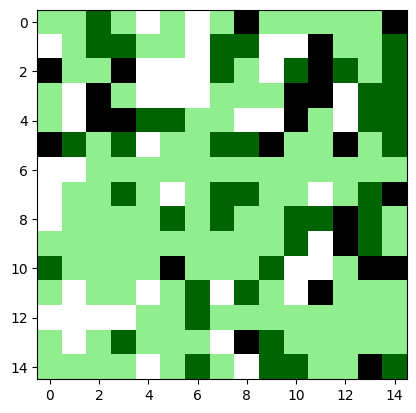

In [14]:

if(TEST_VIEW_SINGLE_STEP):

    actions = []
    for s in state:
        input = torch.from_numpy(s[0]).float().to(device)  
        water_res = torch.tensor([[s[1]]]).float().to(device)
        if model_name == '':
            action_i = policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1)
        elif model_name == 'PG':
            action_i = torch.argmax(policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1))
        elif model_name == 'AC':
            action_i, _ = policy_net(input.unsqueeze(0), water_res)
            action_i = action_i.max(1)[1].view(1, 1)
        else:
            raise Exception
        action_int = action_i.item()
        action = [action_int % 5, int(action_int / 5)]
        actions.append(action)
    print(actions)

    next_state, reward, done = env.step(actions)
    # print(next_state)
    print(reward)
    env.mapEnv.plotAgent()
    # env.mapEnv.plotAll()
    env.mapEnv.plotFireMap()
    env.mapEnv.plotEnvMap()
    
    total_reward += sum(reward)

    state = next_state

    if done:
        print("DONE")